In [55]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split


#from preprocessing import preprocess
plt.rcParams["figure.dpi"] = 150

In [2]:
# from collections import Counter
# import requests

# with requests.get(
#     "https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv") as r, open("features.csv", "wb") as f:
#     for chunk in r.iter_content():
#         f.write(chunk)

# with requests.get(
#     "https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv") as r, open("target.csv", "wb") as f:
#     for chunk in r.iter_content():
#         f.write(chunk)

In [3]:
df_features = pd.read_csv("features.csv")
df_target = pd.read_csv("target.csv")
df = df_features.merge(df_target, left_on='id', right_on='id')

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.drop(columns=['id', 'dia', 'barrio'])[df.duplicated(keep=False)]

,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,llovieron_hamburguesas_hoy,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente


In [5]:
#Convertimos la presion a un tipo numérico, establecimos los valores inválidos como NaN.
df['presion_atmosferica_tarde'] = pd.to_numeric(df['presion_atmosferica_tarde'],errors='coerce')    
#Convertimos las fechas al tipo datetime.
df['dia'] = pd.to_datetime(df['dia'])

#Eliminamos todas las filas del dataframe donde haya valores faltantes
df = df.dropna(subset=['llovieron_hamburguesas_al_dia_siguiente']) 
df = df.dropna(subset=['llovieron_hamburguesas_hoy']) 


#Eliminamos las dos columnas con mayor porcentaje de missings
df = df.drop(columns = ['horas_de_sol', 'mm_evaporados_agua']) 
#df = df.drop(columns = ['nubosidad_tarde', 'nubosidad_temprano']) 

df = df.drop(columns = ['id'])

#Llenamos las columnas con grandes porcentajes de missings con la mean
#df['horas_de_sol'] = df['horas_de_sol'].fillna(df['horas_de_sol'].mean())
#df['mm_evaporados_agua'] = df['mm_evaporados_agua'].fillna(df['mm_evaporados_agua'].mean())

df['nubosidad_tarde'] = df['nubosidad_tarde'].fillna(df['nubosidad_tarde'].mean())
df['nubosidad_temprano'] = df['nubosidad_temprano'].fillna(df['nubosidad_temprano'].mean())
df['presion_atmosferica_temprano'] = df['presion_atmosferica_temprano'].fillna(df['presion_atmosferica_temprano'].mean())
df['presion_atmosferica_tarde'] = df['presion_atmosferica_tarde'].fillna(df['presion_atmosferica_tarde'].mean())
df['rafaga_viento_max_velocidad'] = df['rafaga_viento_max_velocidad'].fillna(df['rafaga_viento_max_velocidad'].mean())
df['humedad_tarde'] = df['humedad_tarde'].fillna(df['humedad_tarde'].mean())
df['temperatura_tarde'] = df['temperatura_tarde'].fillna(df['temperatura_tarde'].mean())
df['mm_lluvia_dia'] = df['mm_lluvia_dia'].fillna(df['mm_lluvia_dia'].mean())
df['velocidad_viendo_tarde'] = df['velocidad_viendo_tarde'].fillna(df['velocidad_viendo_tarde'].mean())
df['humedad_temprano'] = df['humedad_temprano'].fillna(df['humedad_temprano'].mean())
df['velocidad_viendo_tarde'] = df['velocidad_viendo_tarde'].fillna(df['velocidad_viendo_tarde'].mean())
df['velocidad_viendo_temprano'] = df['velocidad_viendo_temprano'].fillna(df['velocidad_viendo_temprano'].mean())
df['temperatura_temprano'] = df['temperatura_temprano'].fillna(df['temperatura_temprano'].mean())
df['temp_min'] = df['temp_min'].fillna(df['temp_min'].mean())
df['temp_max'] = df['temp_max'].fillna(df['temp_max'].mean())

In [6]:
df = df.drop(columns = ['direccion_viento_temprano', 'rafaga_viento_max_direccion', 'direccion_viento_tarde']) 

In [7]:
df = df.drop(columns = ['dia', 'barrio'])

In [8]:
def feature_engineering(df):
    """Hace las transformaciones de datos necesarias."""
    #df = pd.get_dummies(df, drop_first=True, columns=['direccion_viento_temprano', 'rafaga_viento_max_direccion', 'direccion_viento_tarde'])

    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(df['llovieron_hamburguesas_al_dia_siguiente'])
    label_encoder.fit(df['llovieron_hamburguesas_hoy'])
    df['llovieron_hamburguesas_hoy'] = label_encoder.transform(df['llovieron_hamburguesas_hoy'])
    X = df.drop(columns=['llovieron_hamburguesas_al_dia_siguiente'])
    y = label_encoder.transform(df['llovieron_hamburguesas_al_dia_siguiente'])

    return X, y, df, label_encoder


X, y, df, y_encoder = feature_engineering(df)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
clf = tree.DecisionTreeClassifier(
        max_depth=8, min_samples_leaf=73
    )
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=73)

In [41]:
sorted(list(zip(X.columns, clf.feature_importances_)), key=lambda x: -x[1])

[('humedad_tarde', 0.6795268572174242),
 ('rafaga_viento_max_velocidad', 0.0973671721813569),
 ('presion_atmosferica_tarde', 0.07665557499253324),
 ('mm_lluvia_dia', 0.05895676365989726),
 ('nubosidad_tarde', 0.03282683417903404),
 ('temperatura_temprano', 0.016397776438217136),
 ('temp_min', 0.009917471627325822),
 ('humedad_temprano', 0.009125572108516918),
 ('temperatura_tarde', 0.005285388355503587),
 ('presion_atmosferica_temprano', 0.004323296462771904),
 ('velocidad_viendo_temprano', 0.003196282874345113),
 ('temp_max', 0.0030498605461975344),
 ('velocidad_viendo_tarde', 0.0026164722149236426),
 ('nubosidad_temprano', 0.0007546771419526882),
 ('llovieron_hamburguesas_hoy', 0.0)]

In [48]:
y_pred = clf.predict(X_test)

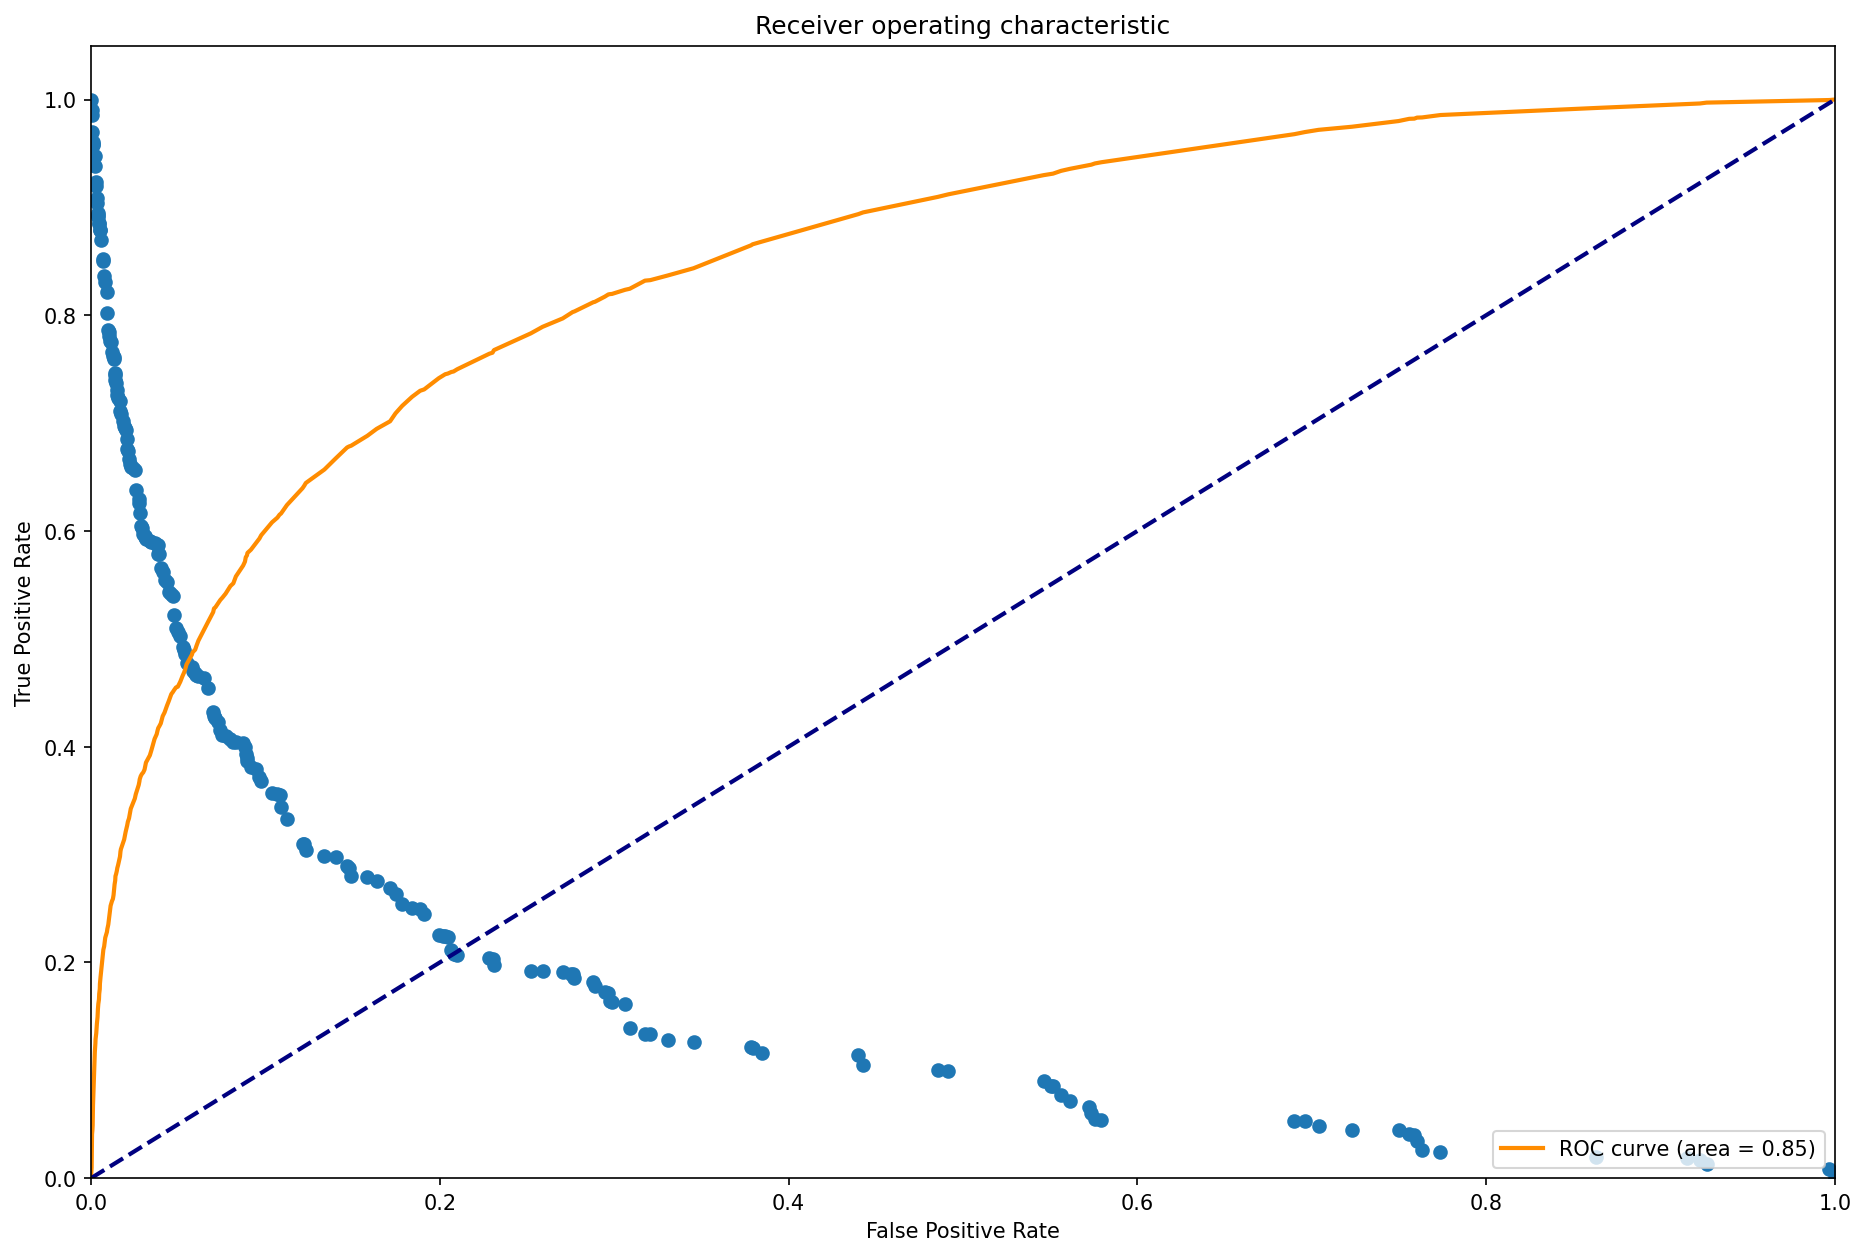

In [58]:
def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plot_roc(fpr, tpr, thresholds)


In [49]:
accuracy_score(y_test, y_pred)

0.8402543426521261

In [50]:
roc_auc_score(y_test, y_pred)

0.7045493511784567

In [33]:
precision_score(y_test, y_pred)

0.720912738214644

In [34]:
recall_score(y_test, y_pred)

0.4622186495176849

In [37]:
max_depths = np.arange(1, 10)
min_samples_leafs = np.arange(1, 100)
data_points = []
for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        clf = tree.DecisionTreeClassifier(
            max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=117
        )
        clf.fit(X_train, y_train)
        data_points.append(
            (max_depth, min_samples_leaf, roc_auc_score(y_test, clf.predict(X_test)),)
        )

data_points = pd.DataFrame(
    data_points, columns=["max_depth", "min_samples_leaf", "score"]
)

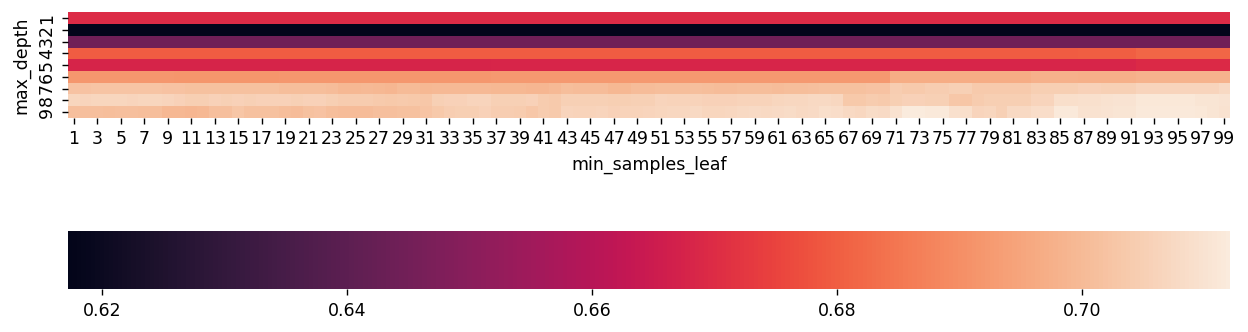

In [38]:
plt.figure(dpi=125, figsize=(12, 8))
g = sns.heatmap(
    data_points.pivot_table(
        index="max_depth", columns="min_samples_leaf", values="score"
    ),
    square=True,
    cbar_kws=dict(use_gridspec=False, location="bottom"),
)

In [ ]:
##min_samples_leaf: 73, max_depth: 8 para maximizar accuracy